In [1]:
%matplotlib inline
from common import *

# Old Valuations

In [2]:
tests_path = os.path.join(locate_lib('vecfunc'), 'vecfunclib/vcg/tests')
d = sim_data.read_data(os.path.join(tests_path, '2d_uint32.msgpack'))
v1 = d['v1'].astype(np.float)
v2 = d['v2'].astype(np.float)
res_size = d['res-size']

In [9]:
vecfunc.is_rising(v2)

True

<IPython.core.display.Javascript object>


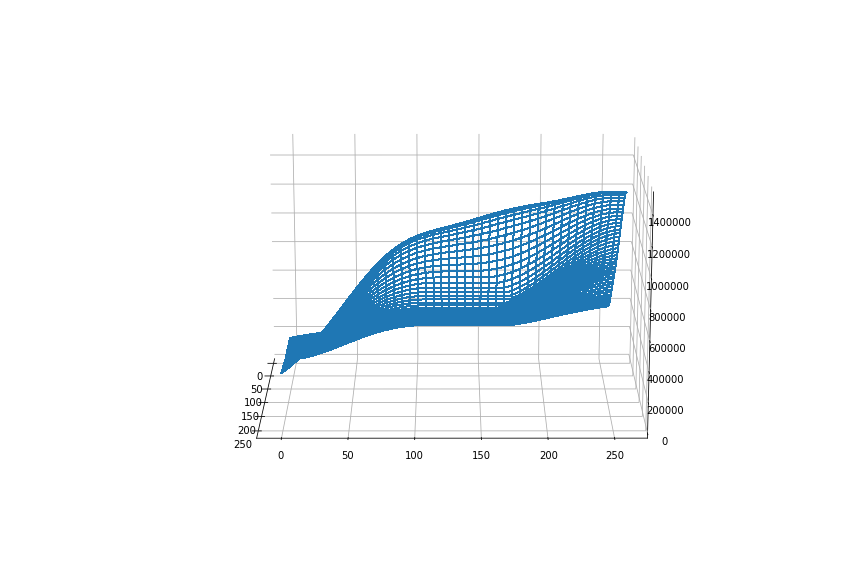

In [8]:
%matplotlib notebook
plt.figure(figsize=(12,8))
vecfunc.plot(v1, force_wire_2d=True, linewidth=1)

In [7]:
s = vecfunc.vcg.jointfunclib.JoinedVecFunc(v2, v1, res_size, method=5, chunk_size=8, flags=('filter', 'count', 'buildtime', 'querytime'))

In [9]:
s.stats

{'bruteForceCount': 0,
 'comparedBruteForce': nan,
 'comparedEdgePoints': 15.144771306151494,
 'comparedInBoundPoints': 19.370194855334677,
 'comparedPoints': 19.370194855334677,
 'dsBuildTime': 0.116004577,
 'dsCreatePointsTime': 0.001511799,
 'dsQueryFetchTime': 0.0778668520000211,
 'dsQueryTime': 0.028277791999999552,
 'expectedComparedPoints': 448.4787506245363,
 'joinedFuncCount': 1,
 'method': 'Category Tree',
 'totalRuntime': 0.267033083}

# Gradient Scatter

In [3]:
g1 = vecfunc.calc_gradients(v1)
g2 = vecfunc.calc_gradients(v2)

Building vecfunc module for: (dim=2, value=float64, flag=). CMD: make  dim=2 value=float64


/home/liran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


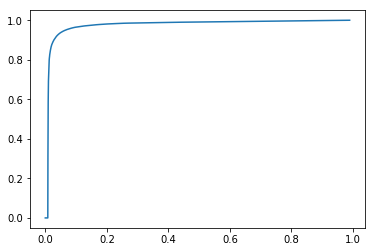

In [6]:
g1_f = g1.reshape(-1, 4)
g2_f = g2.reshape(-1, 4)
t = np.minimum(g1_f[:, 0], g1_f[:, 1]) / np.maximum(g1_f[:, 0], g1_f[:, 1])
plt.plot(np.linspace(0, 1, len(t)),np.sort(t))

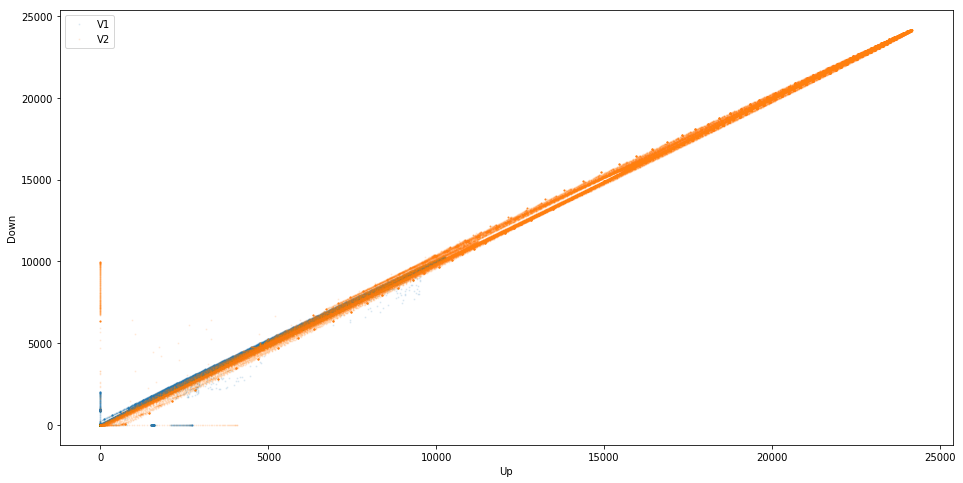

In [4]:
plt.figure(figsize=(16,8))
g1_f = g1.reshape(-1, 4)
g2_f = g2.reshape(-1, 4)

plt.scatter(g1_f[:, 0], g1_f[:, 1], s=1, alpha=0.1, label='V1')

# plt.scatter(g1_f[m, 2], g1_f[m, 3], s=1, alpha=0.1)

plt.scatter(g2_f[:, 1], g2_f[:, 0], s=1, alpha=0.1, label='V2')

# plt.scatter(g2_f[m, 2], g2_f[m, 3], s=1, alpha=0.1)

plt.xlabel("Up")
plt.ylabel("Down")
plt.legend()
None

# Verify Checksum

In [6]:
a,b = np.meshgrid(*map(range, v2.shape), indexing='ij')
np.sum(a*v2 + b*v2)

50190536301215

In [5]:
v1.sum(), v2.sum()

(41925536837, 159620448713)

# Compare DS

In [9]:
test = [(0, None), (1, None),
        (2, 8), (2, 128),
        (3, 16), (3, 32), (3, 64), (3, 128),
        (4, 128), (4, 256), (4, 512), (4, 1024), 
        (5, 128), (5, 256), (5, 512), (5, 1024),
        (6, 32), (6, 64), (6, 128), (6,512),
        (7, 64),
#         (8, 64), (9, 64), (10, 64), (11, 64),
       ]
v = [vecfunc.vcg.jointfunclib.JoinedVecFunc(v2, v1, res_size, method=m, chunk_size=c, join_stats=True) for m, c in test]

err = np.where(np.logical_not([np.allclose(v[0].arr, vv.arr) for vv in v[1:]]))[0] + 1
print('Error Count:', len(err))
for i in err:
    print(test[i], np.abs(v[0].arr.astype(float) - v[i].arr.astype(float)).mean())

for i in err:
    print(test[i], np.unravel_index(np.abs(v[0].arr.astype(float) - v[i].arr.astype(float)).argmax(), v[0].arr.shape))

Building vecfunc module for: (dim=2, value=float64, flag=stats). CMD: make stats dim=2 value=float64


Error Count: 0


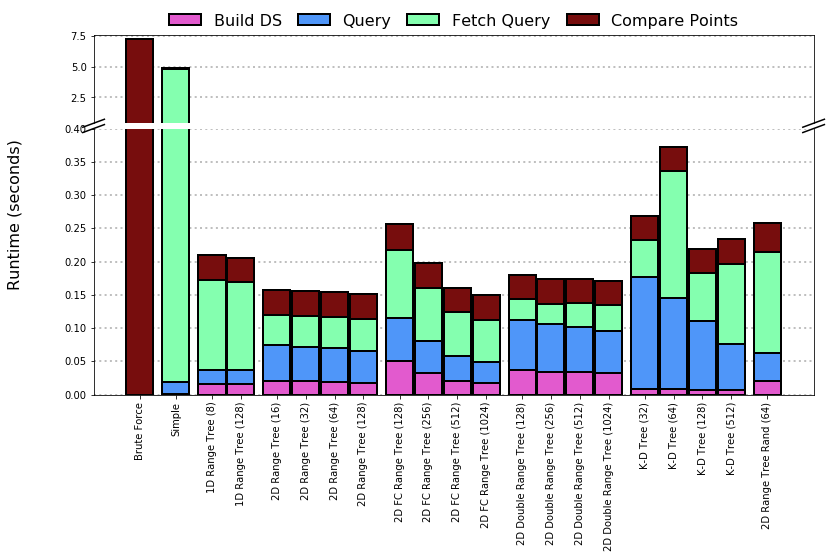

In [10]:
totalRuntime = np.array([vv.stats['totalRuntime'] for vv in v])
dsBuildTime = np.array([vv.stats['dsBuildTime'] for vv in v])
dsQueryTime = np.array([vv.stats['dsQueryTime'] for vv in v])
dsQueryFetchTime = np.array([vv.stats['dsQueryFetchTime'] for vv in v])
v_labels = map(lambda v_arg: v_arg.stats['method'], v)
labels = ["%s (%s)" % (vlbl, c) if c is not None else vlbl for vlbl, (m, c) in zip(v_labels, test)]

width=0.75
min_space=0.05
inds = np.arange(len(totalRuntime)).astype(float)
for i in range(1, len(v)):
    if v[i-1].method == v[i].method:
        inds[i:] -= 1-width-min_space

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5), gridspec_kw = {'height_ratios':[1, 3]})
init_plot(16)
fig.subplots_adjust(0,0,1,1,0,0.03)

for ax in (ax1, ax2):
    ax.bar(inds, dsBuildTime, color='#e25ace', label='Build DS',
          edgecolor='black', linewidth=2, zorder=10, width=width)
    ax.bar(inds, dsBuildTime+dsQueryTime, color='#4f96f9', label='Query',
          edgecolor='black', linewidth=2, zorder=9, width=width)
    ax.bar(inds, dsBuildTime+dsQueryTime+dsQueryFetchTime, color='#84ffaf', label='Fetch Query',
          edgecolor='black', linewidth=2, zorder=8, width=width)
    ax.bar(inds, totalRuntime, color='#770d0d', label='Compare Points', edgecolor='black',
          linewidth=2, zorder=7, width=width)
    
break_portion = 0.40
ax1.set_ylim(break_portion, None)  # outliers only
ax2.set_ylim(0, break_portion)  # most of the data

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d*3, +d*3), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d*3, +d*3), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.xaxis.grid(False)
ax1.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

ax2.xaxis.grid(False)
ax2.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

ax1.xaxis.set_ticks_position('none') 
ax2.set_xticks(inds)
ax2.set_xticklabels(labels)
# plt.xticks(inds, labels, rotation=90)
plt.xticks(rotation=90)

arts = []
arts.append(fig.text(-0.12, 0.5, 'Runtime (seconds)', va='center', rotation='vertical'))
arts.append(ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4,
                       frameon=False, columnspacing=1))
None

In [9]:
print(totalRuntime - (dsBuildTime+dsQueryTime+dsQueryFetchTime))

[5.88473973 0.04032807 0.03910299 0.03528886 0.03527606 0.03921273
 0.03781248 0.08552317]


In [10]:
dsQueryFetchTime

array([0.        , 3.67821958, 0.76898698, 0.18180851, 0.21444668,
       0.23929494, 0.54152863, 0.9348591 ])

# Generate 1D Valuations

In [2]:
p_count = 128

init_val = [vecfunc.rand.init_sample_1d_concave() for _ in range(p_count)]
val_xy = [vecfunc.vecinterp.refine_chaikin_corner_cutting_xy(*p) for p in init_val]
eps = np.finfo(np.float32).eps

from scipy.interpolate import CubicSpline
val_spline = [CubicSpline(v[0], v[1], bc_type='natural') for v in val_xy]

In [3]:
val_sizes = np.linspace(2**10, 2**19, 10).astype(np.uint32)
val_x = [np.linspace(0,1,s) for s in val_sizes]
vals = [np.array([v(x) for v in val_spline]) for x in val_x]

for vs in vals:
    for i in range(p_count):
        vs[i] = vecfunc.fix_concave_rising(vs[i]).arr
# difs = [np.diff(v) for v in vals]

In [4]:
for j, vs in enumerate(vals):
    for i in range(p_count):
        assert vecfunc.is_rising(vs[i]), "Error in %s - %s" % (j, i)

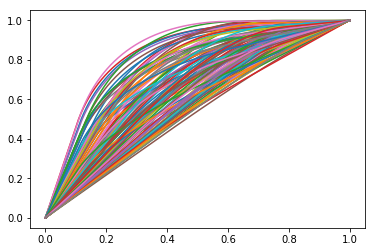

In [5]:
for i in range(p_count):
    plt.plot(val_x[0], vals[0][i])

In [8]:
vecfunc.vcg.jointfunclib.join_all(vals, val_size, method=3)

NameError: name 'val_size' is not defined

In [33]:
res = []
for vs, s in zip(vals, val_sizes):
    b = vecfunc.vcg.maille_tuffin(vs, s)
#     a0 = vecfunc.vcg.joint_func(vs, s, join_method=0, join_chunk_size=8, join_stats=False)
#     a2 = vecfunc.vcg.joint_func(vs, s, join_method=2, join_chunk_size=8, join_stats=False)
    a3 = vecfunc.vcg.joint_func(vs, s, join_method=3, join_chunk_size=8, join_flags=('filter', 'count', 'buildtime', 'querytime'))
#     a6 = vecfunc.vcg.joint_func(vs, s, join_method=6, join_chunk_size=128, join_stats=False)
#     res.append((b, a0, a2, a3, a6))
    res.append((b, a3))
    print('Val Size:', s)

Val Size: 1024
Val Size: 59164
Val Size: 117304
Val Size: 175445
Val Size: 233585
Val Size: 291726
Val Size: 349866
Val Size: 408007
Val Size: 466147
Val Size: 524288


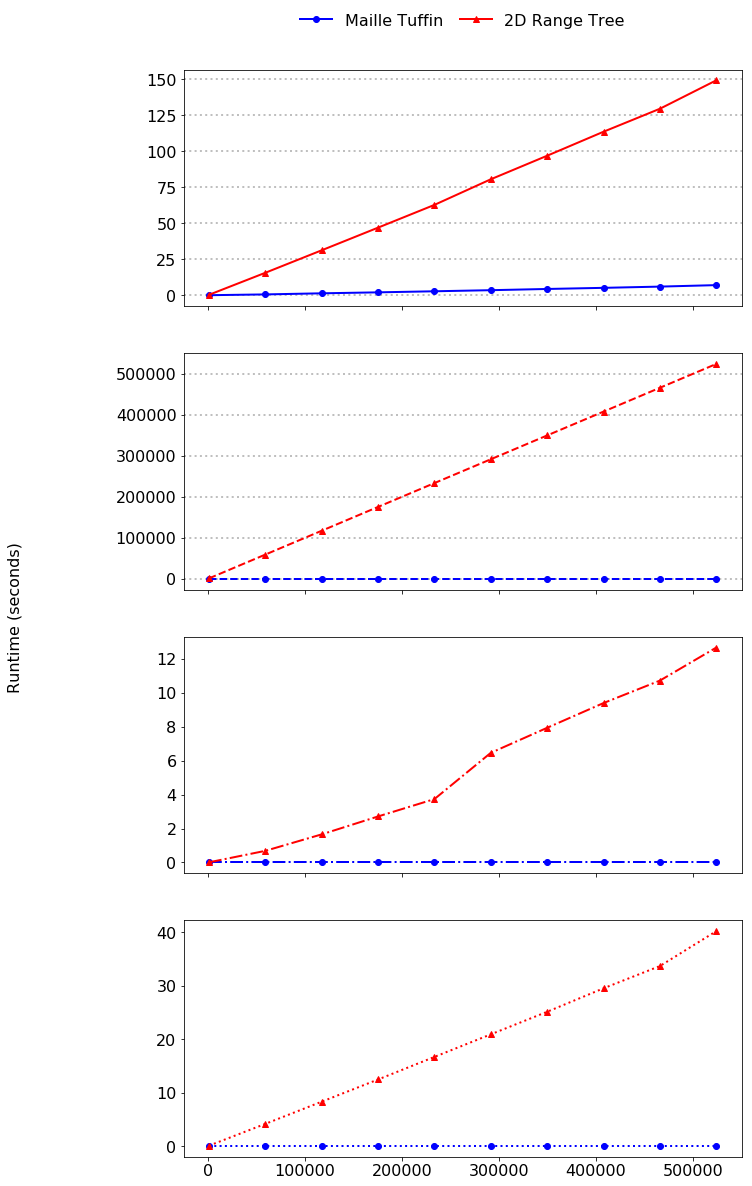

In [34]:
res_named = {}
res_count = {}
res_build = {}
res_query = {}
for s, r in zip(val_sizes, res):
    labels = [stats['stats']['method'] for stats in r]
    runtime = [stats['stats']['optimizationRunTime'] for stats in r]
    count = [stats['stats']['combinationCount'] / stats['stats']['joinedFuncCount'] if stats['stats']['joinedFuncCount'] > 0 else 0 for stats in r]
    build = [stats['stats']['dsBuildTime'] for stats in r]
    query = [stats['stats']['dsQueryTime'] for stats in r]
    for k, v, c, b, q in zip(labels, runtime, count, build, query):
        res_named.setdefault(k, []).append(v)
        res_count.setdefault(k, []).append(c)
        res_build.setdefault(k, []).append(b)
        res_query.setdefault(k, []).append(q)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,20))
init_plot(16)

markers = 'o', '^', 's', '8', 'x', '*', 'D'
colors = 'blue', 'red'
marker_index = 0
for k, v in res_named.items():
    ax1.plot(val_sizes, v, label=k, linewidth=2, marker=markers[marker_index], color=colors[marker_index])
    ax2.plot(val_sizes, res_count[k], linestyle='--', linewidth=2, marker=markers[marker_index], color=colors[marker_index])
    ax3.plot(val_sizes, res_build[k], linestyle='-.', linewidth=2, marker=markers[marker_index], color=colors[marker_index])
    ax4.plot(val_sizes, res_query[k], linestyle=':', linewidth=2, marker=markers[marker_index], color=colors[marker_index])
    marker_index += 1
    
ax1.xaxis.grid(False)
ax1.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

ax2.xaxis.grid(False)
ax2.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

arts = []
arts.append(fig.text(-0.12, 0.5, 'Runtime (seconds)', va='center', rotation='vertical'))
arts.append(ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=5,
                       frameon=False, columnspacing=1))
None

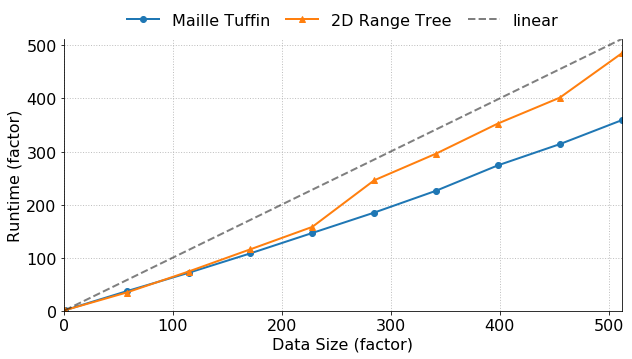

In [14]:
res_named = {}
for s, r in zip(val_sizes, res):
    labels = [stats['stats']['method'] for stats in r]
    runtime = [stats['stats']['optimizationRunTime'] for stats in r]
    sw = [stats['sw'] for stats in r]
    assert np.allclose(sw, sw[0])
    for k, v in zip(labels, runtime):
        res_named.setdefault(k, []).append(v)
        
for k, v in res_named.items():
    res_named[k] = np.array(v) / v[0]

plt.figure(figsize=(10, 5))
init_plot(16)
ax = plt.gca()

markers = 'o', '^', 's', 'x', '*', 'D'
marker_index = 0
for k, v in res_named.items():
    if k not in ['Maille Tuffin', '2D Range Tree']:
        continue
    ax.plot(val_sizes / val_sizes[0], v, label=k, linewidth=2, marker=markers[marker_index], clip_on=True)
    marker_index += 1
    
plt.plot(val_sizes / val_sizes[0], val_sizes / val_sizes[0], label="linear", linewidth=2, linestyle="--",
        color='black', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.grid(True, linestyle=':', alpha=0.8, linewidth=1)
plt.xlim(0,(val_sizes / val_sizes[0])[-1])
plt.ylim(0,(val_sizes / val_sizes[0])[-1])

plt.xlabel("Data Size (factor)")
plt.ylabel('Runtime (factor)')
arts = []
arts.append(plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5,
                       frameon=False, columnspacing=1))
None

In [18]:
b = vecfunc.vcg.maille_tuffin(vals, val_size)

In [19]:
a0 = vecfunc.vcg.joint_func(vals, val_size, join_method=0, join_chunk_size=8, join_stats=False)

In [20]:
a2 = vecfunc.vcg.joint_func(vals, val_size, join_method=2, join_chunk_size=8, join_stats=False)

In [21]:
a3 = vecfunc.vcg.joint_func(vals, val_size, join_method=3, join_chunk_size=8, join_stats=False)

In [22]:
a6 = vecfunc.vcg.joint_func(vals, val_size, join_method=6, join_chunk_size=128, join_stats=False)

In [11]:
a3['sw'], b['sw']

(3.9061527008485513, 3.906152700848551)

In [14]:
b['stats']

{'combinationCount': 0,
 'comparedPoints': 0.0,
 'dsBuildTime': 0.0,
 'dsQueryFetchTime': 0.0,
 'dsQueryTime': 0.0,
 'expectedCombinationCount': 0,
 'expectedComparedPoints': 0.0,
 'joinedFuncCount': 0,
 'method': 'Maille Tuffin',
 'optimizationRunTime': 0.019344329833984375,
 'totalRuntime': 0.0025714199999999996}

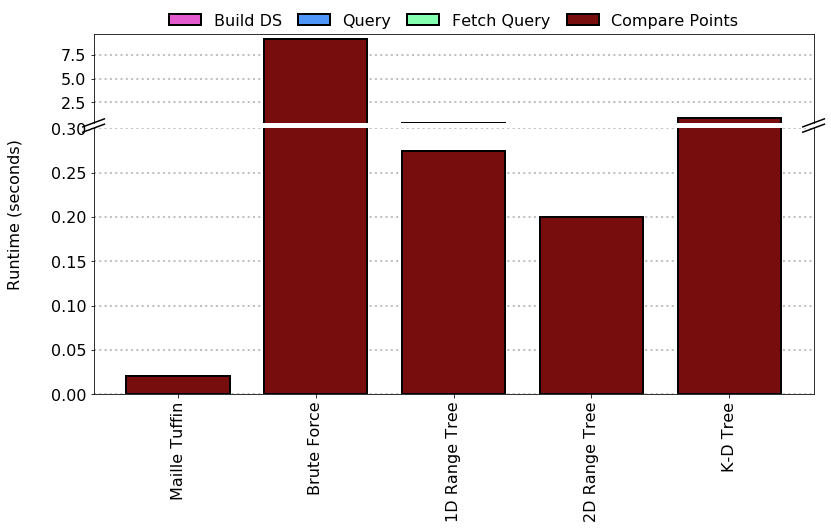

In [24]:
ret_stats = [r['stats'] for r in (b, a0, a2, a3, a6)]
totalRuntime = np.array([s['totalRuntime'] for s in ret_stats])
dsBuildTime = np.array([s['dsBuildTime'] for s in ret_stats])
dsQueryTime = np.array([s['dsQueryTime'] for s in ret_stats])
dsQueryFetchTime = np.array([s['dsQueryFetchTime'] for s in ret_stats])
v_labels = map(lambda s: s['method'], ret_stats)
labels = list(v_labels)

width=0.75
min_space=0.05
inds = np.arange(len(totalRuntime)).astype(float)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5), gridspec_kw = {'height_ratios':[1, 3]})
init_plot(16)
fig.subplots_adjust(0,0,1,1,0,0.03)

for ax in (ax1, ax2):
    ax.bar(inds, dsBuildTime, color='#e25ace', label='Build DS',
          edgecolor='black', linewidth=2, zorder=10, width=width)
    ax.bar(inds, dsBuildTime+dsQueryTime, color='#4f96f9', label='Query',
          edgecolor='black', linewidth=2, zorder=9, width=width)
    ax.bar(inds, dsBuildTime+dsQueryTime+dsQueryFetchTime, color='#84ffaf', label='Fetch Query',
          edgecolor='black', linewidth=2, zorder=8, width=width)
    ax.bar(inds, totalRuntime, color='#770d0d', label='Compare Points', edgecolor='black',
          linewidth=2, zorder=7, width=width)
    
break_portion = 0.3
ax1.set_ylim(break_portion, None)  # outliers only
ax2.set_ylim(0, break_portion)  # most of the data

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d*3, +d*3), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d*3, +d*3), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.xaxis.grid(False)
ax1.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

ax2.xaxis.grid(False)
ax2.yaxis.grid(True, linestyle=':', alpha=0.8, linewidth=2)

ax1.xaxis.set_ticks_position('none') 
ax2.set_xticks(inds)
ax2.set_xticklabels(labels)
# plt.xticks(inds, labels, rotation=90)
plt.xticks(rotation=90)

arts = []
arts.append(fig.text(-0.12, 0.5, 'Runtime (seconds)', va='center', rotation='vertical'))
arts.append(ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4,
                       frameon=False, columnspacing=1))
None

In [64]:
np.array(a['allocations']).shape

(128, 1)

In [8]:
list(zip(np.array(a['allocations'])[:,0], b['allocations']))

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (123, 123),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (63, 63),
 (0, 0),
 (116, 116),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (122, 122),
 (0, 0),
 (122, 122),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (123, 123),
 (0, 0),
 (0, 0),
 (0, 0),
 (132, 132),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (113, 113),
 (0, 0),
 (0, 0),
 (0, 0)

In [24]:
x = [1,2,3]
x[::-1]

[3, 2, 1]

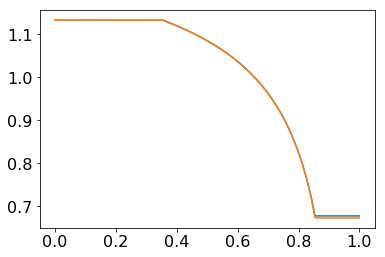

In [27]:
p = 14
plt.plot((val_xy[p][0][1:]+val_xy[p][0][:-1])/2, np.diff(val_xy[p][1])/np.diff(val_xy[p][0]))
plt.plot((val_x[1:]+val_x[:-1])/2, np.diff(new_vals[p])/(val_x[1]-val_x[0]))

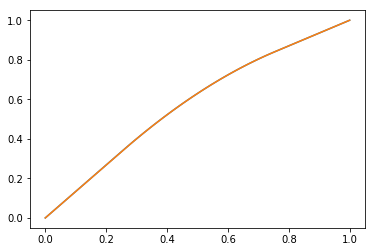

In [11]:
plt.plot(*val_xy[p])
plt.plot(val_x, vals[p])

In [88]:
s = 2**38
g = 2**24
from math import log2
c = int(2**38 / 2**24)
logc = int(log2(c))
c, logc

(16384, 14)

In [94]:
v = [1,2,3]
g = [1,1]
while v[-1] < c:
    g.append(g[-1]+g[-2])
    v.append(v[-1] + g[-1])
np.set_printoptions(suppress=True)
len(v), v, np.array(g, dtype=float)*16

(21,
 [1,
  2,
  3,
  5,
  8,
  13,
  21,
  34,
  55,
  89,
  144,
  233,
  377,
  610,
  987,
  1597,
  2584,
  4181,
  6765,
  10946,
  17711],
 array([    16.,     16.,     32.,     48.,     80.,    128.,    208.,
           336.,    544.,    880.,   1424.,   2304.,   3728.,   6032.,
          9760.,  15792.,  25552.,  41344.,  66896., 108240.]))

# Tests

In [28]:
sd = data.concave.load_data(0)
sd

SimulationData({ 'folder-format': '{ndim}d-{n}p',
  'generate-time': 0.18939805030822754,
  'index': 0,
  'n': 256,
  'name': 'optimization-concave-6d-256p',
  'ndim': 6,
  'prefix': 'optimization-concave',
  'seed': 1663928292,
  'valuation': { 'concave': True,
                 'local-maximum-limit': None,
                 'wealth-dist': ['lomax', 1.160964047443681, [0, 128]]}})

In [40]:
sd.dist_data['wealth']

array([  2.12772906,  25.67821612,   5.88426672,   2.71403568,
        85.10785255,   1.38820415,  11.94363401,  22.1354136 ,
        10.84827294,   4.2081845 ,  14.75023507,   2.56340351,
         5.65918389,   5.24245209,   3.40226515,   9.94638958,
         1.67334856,   6.10527716,   5.9629872 ,   6.62175205,
        20.98860296,   2.36206267,   4.9373948 ,   3.63256377,
         1.1362404 ,  10.3290033 ,   7.18650474,  38.00407038,
        28.73261889,   3.33316135,   2.29312354,  14.43926978,
         9.61726828,  10.3877034 ,   1.78582519,   5.82091385,
         6.94378142,   1.24899928,   4.95412493,   4.66213817,
         5.76494754,  23.86882158,   9.37704245,   5.53556471,
         3.04383097,   7.12655248,  11.66638235,   2.63472242,
         6.63112384,   3.47005612,   5.96102494,   2.37688581,
        28.68975089,   3.02016452,   1.62269481,   3.41533875,
         3.93096815,  15.40891925,   1.68663863,   5.03965168,
        11.92796913, 127.96260195,   6.46128867,   9.11

In [62]:
val_slices, vals = data.produce.get_vals(sd, (16,), ndim=1, factor_wealth=True)

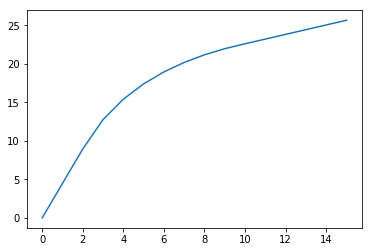

In [63]:
plt.plot(val_slices[1][0])

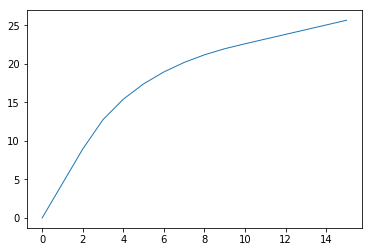

In [64]:
vecfunc.plot(vals[1], force_wire_2d=True, linewidth=1)

In [25]:
v = vals[1]
g = v[1:] - v[:-1]
1/g.mean()

15.0

In [26]:
gg = np.abs(g[1:] - g[:-1])
gg.mean()

0.022284214812033337

In [36]:
w = {"v%s" % i: v for i, v in enumerate(vals)}
w['res-size'] = vals[0].shape
sim_data.write_data(w, "4d_float64.msgpack")

In [2]:
tested_dims = 1, 2, 3, 4, 5, 6
sim_kwargs = dict(datasets_interval=(0,1), max_workers=1)

In [2]:
sizes = np.linspace(2**10, 2**16, 3).astype(np.uint32)
dims = 2, #1,2,3,4,5,6
print(sizes)
print(dims)

[ 1024 33280 65536]
(2,)


In [35]:
[(x, exp.param.get_shape_for_gridpoints(x, 3)) for x in sizes]

[(16777216, (255, 255, 258))]

In [3]:
exp.batch.joint_val(
    ds_obj=data.nonconcave,
    exp_type='test-fg',
    
    sizes=sizes,
    dims=dims,
    join_methods=(5,),
    join_chunk_size=8,
    join_flags=('filter_grad', 'filter', 'count', 'buildtime'),
    sim_kwargs=dict(max_workers=1, datasets_interval=(0,1)),
)

In [13]:
exp.batch.maille_tuffin(
    ds_obj=data.concave,
    exp_type='test-maille',
    sim_kwargs=dict(max_workers=1, datasets_interval=(0,1)),
    
    sizes=sizes,
    dims=dims,
)

In [3]:
maille_tuffin_sizes = np.linspace(2**10, 2**16, 10).astype(np.uint32)
exp.batch.maille_tuffin(data.concave, exp_type='maille-tuffin',
                        sizes=maille_tuffin_sizes,
                        dims=tested_dims,
                        sim_kwargs=sim_kwargs)

In [37]:
np.max(vals[0]), np.max(vals[2])

(2.4598629121190543, 2.5837876126194534)

In [6]:
sim.destroy_executors()

Total ran simulations: 60


,Name,Alive,Started,Work Time,Event State
0,batch-sim-jobs,True,17:50:23,1:27 minutes,False


,Name,Alive,T,D,F,R,Q,C,Started,Work Time,Last Update,Throughput,ETA
0,maille-tuffin/6-65536[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:04,0.79 seconds,17:51:05,1.26 items/second,N/A
1,maille-tuffin/6-58368[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:03,0.80 seconds,17:51:04,1.26 items/second,N/A
2,maille-tuffin/6-51200[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:02,0.76 seconds,17:51:03,1.32 items/second,N/A
3,maille-tuffin/6-44032[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:01,0.68 seconds,17:51:02,1.47 items/second,N/A
4,maille-tuffin/6-36864[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:01,0.69 seconds,17:51:01,1.44 items/second,N/A
5,maille-tuffin/6-29696[optimization-concave-6d-256p],False,1,1,0,0,0,0,17:51:00,0.66 seconds,17:51:01,1.50 items/second,N/A


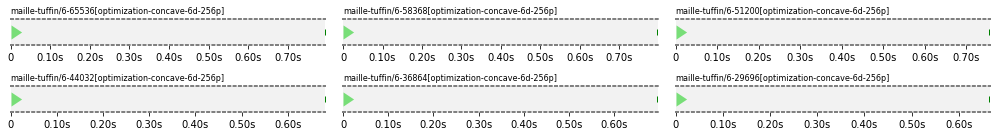

In [12]:
display(*sim.print_simulations_status_joined(show_finished_count=6, progress_columns=3))

In [56]:
exp.batch.get_batch_jobs_list()

,name,dataset


In [5]:
sim.get_simulation('test-fg/5-2-1024[optimization-nonconcave-6d-256p]').results()

AssertionError: SW (153.8485226068308) != SW-reverse (153.49370568374087)

In [33]:
data.nonconcave.clear_cache()

In [19]:
maille_results = [results.read_unified_results(data.concave, 'maille-tuffin', '1')]
for r in maille_results:
    print("Methods:", set([m for m_lst in r['stats', 'method'] for m in m_lst]))

allocs = [r['allocations'] for r in maille_results]
sw = [r['sw'] for r in maille_results]
payments = [r['payments'] for r in maille_results]
private_values = [r['private-values'] for r in maille_results]

maille-tuffin/1-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'Maille Tuffin'}


In [20]:
private_values[0][0,0]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [59]:
all_results = [results.read_unified_results(data.nonconcave, k) for k in ('test-nfg', 'test-fg')]
for r in all_results:
    print("Methods:", set([m for m_lst in r['stats', 'method'] for m in m_lst]))

allocs = [r['allocations'] for r in all_results]
sw = [r['sw'] for r in all_results]
used = [r['used-resources'] for r in all_results]
payments = [r['payments'] for r in all_results]

test-nfg/(.+) - matching: 18 - valid: 18 - total: 18
test-fg/(.+) - matching: 18 - valid: 18 - total: 18
Methods: {'Category Tree'}
Methods: {'Category Tree'}


In [60]:
for a in allocs[1:]:
    print("Matching allocations:", ([np.all(allocs[0][i] == a[i]) for i in range(len(a))]))
    
for s in sw[1:]:
    print("Matching SW:", np.all(np.isclose(sw[0], s)))
    
for u in used[1:]:
    print("Matching Used:", all([np.all(used[0][i] == u[i]) for i in range(len(u))]))
    
for p in payments[1:]:
    print("Matching payments:", np.all(np.isclose(payments[0], p)))

Matching allocations: [True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, True, True, True]
Matching SW: True
Matching Used: True
Matching payments: False


In [46]:
used

[[array([[1023]]),
  array([[8703]]),
  array([[16383]]),
  array([[4, 4, 4, 7]]),
  array([[ 8,  8,  8, 11]]),
  array([[10, 10, 10, 11]]),
  array([[3, 3, 3, 3, 3]]),
  array([[5, 5, 5, 5, 6]]),
  array([[ 5,  5,  5,  5, 12]]),
  array([[2, 2, 2, 2, 2, 3]]),
  array([[3, 3, 3, 3, 3, 7]]),
  array([[4, 4, 4, 4, 4, 4]])],
 [array([[1023]]),
  array([[8703]]),
  array([[16383]]),
  array([[4, 4, 4, 7]]),
  array([[ 8,  8,  8, 11]]),
  array([[10, 10, 10, 11]]),
  array([[3, 3, 3, 3, 3]]),
  array([[5, 5, 5, 5, 6]]),
  array([[ 5,  5,  5,  5, 12]]),
  array([[2, 2, 2, 2, 2, 3]]),
  array([[3, 3, 3, 3, 3, 7]]),
  array([[4, 4, 4, 4, 4, 4]])]]

In [14]:
a = allocs[0][0][0] - allocs[1][0][0]
w = np.where(a != 0)
print(w)
a[w]

(array([ 31,  31,  31,  31, 117, 117, 117, 117]), array([0, 1, 2, 3, 0, 1, 2, 3]))


array([ 4,  4,  4,  7, -4, -4, -4, -7])

In [18]:
payments[0][0][0][w[0]]

array([128., 128., 128., 128.,   0.,   0.,   0.,   0.])

In [63]:
sw[0][0][0]

317.34503334258454

In [19]:
payments[1][0][0][w[0]]

array([  0.,   0.,   0.,   0., 128., 128., 128., 128.])

In [12]:
allocs[0][0].shape

(1, 256, 4)

test-nfg/(.+) - matching: 18 - valid: 18 - total: 18
Methods: {'Category Tree'}


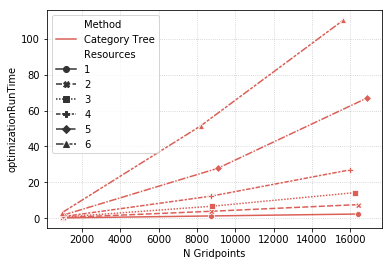

In [61]:
exp_name = 'test-nfg'
exp_prefix = None
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'))

test-fg/(.+) - matching: 18 - valid: 18 - total: 18
Methods: {'Category Tree'}


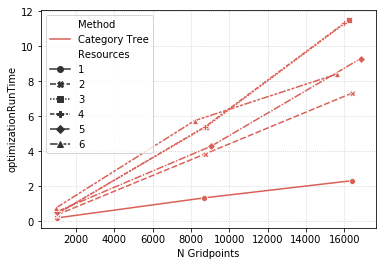

In [62]:
exp_name = 'test-fg'
exp_prefix = None
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'))

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


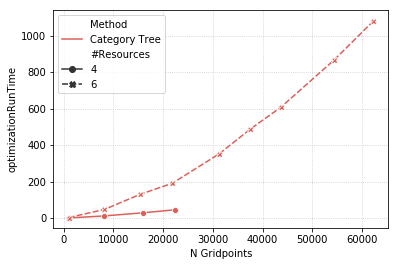

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


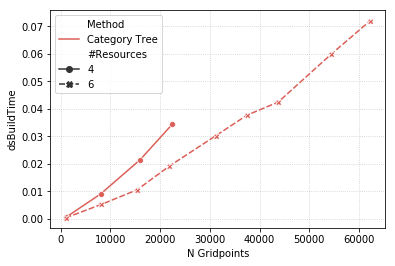

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


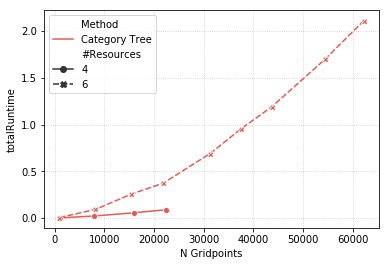

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


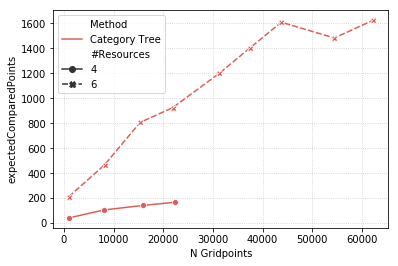

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


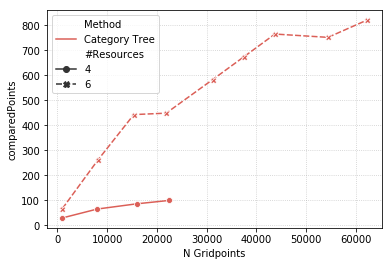

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


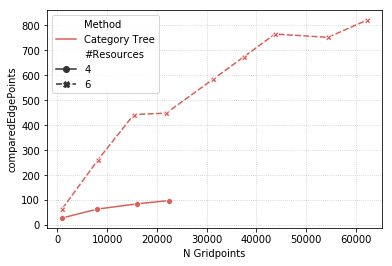

scalability-schunk/(.+) - matching: 14 - valid: 14 - total: 14
Methods: {'Category Tree'}


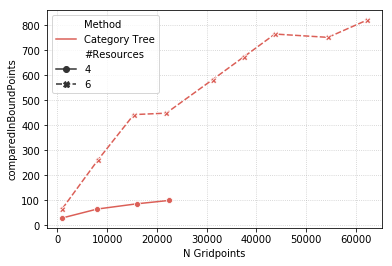

In [46]:
exp_name = 'scalability-schunk'
exp_prefix = None#'5'
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'))
plt.show()
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','dsBuildTime'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','totalRuntime'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
          val=('stats','expectedComparedPoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedPoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedEdgePoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedInBoundPoints'))
plt.show()

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


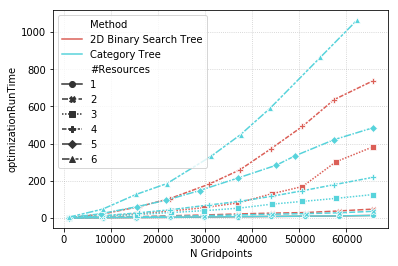

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


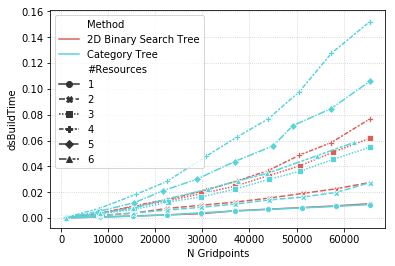

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


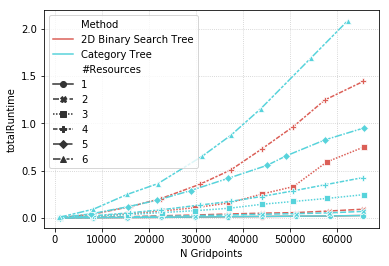

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


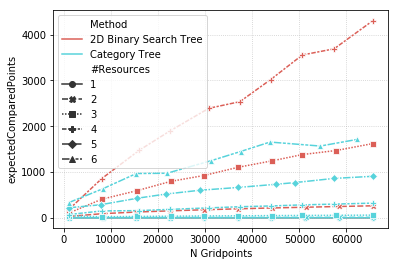

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


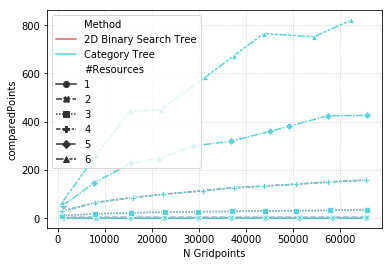

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


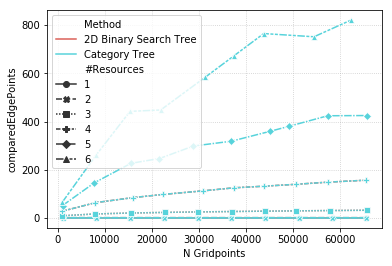

scalability/(.+) - matching: 99 - valid: 99 - total: 99
Methods: {'2D Binary Search Tree', 'Category Tree'}


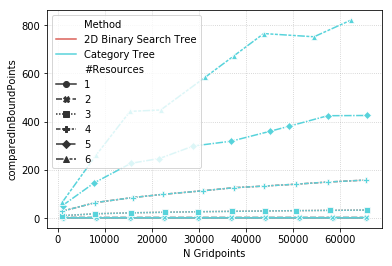

In [31]:
exp_name = 'scalability'
exp_prefix = None#'5'
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'))
plt.show()
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','dsBuildTime'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','totalRuntime'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
          val=('stats','expectedComparedPoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedPoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedEdgePoints'))
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val=('stats','comparedInBoundPoints'))
plt.show()

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}
Resource 2 fit: 8.65219e-08 * n^(1.78)


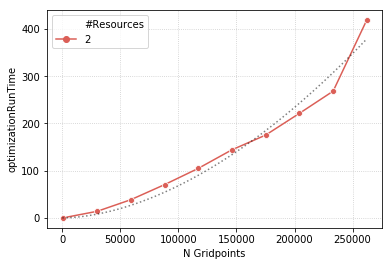

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}
Resource 2 fit: const


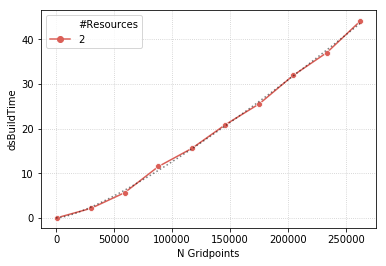

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}
Resource 2 fit: const


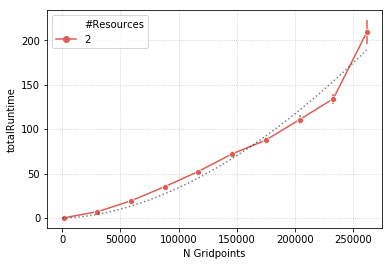

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}


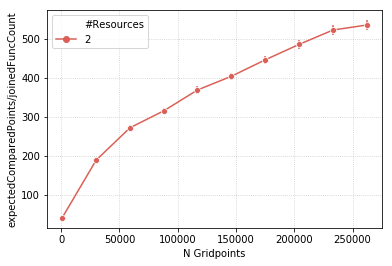

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}


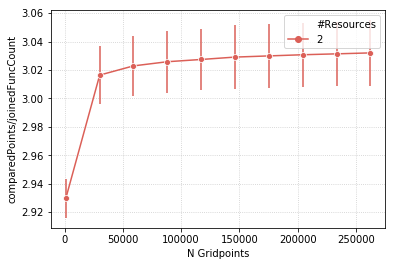

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}


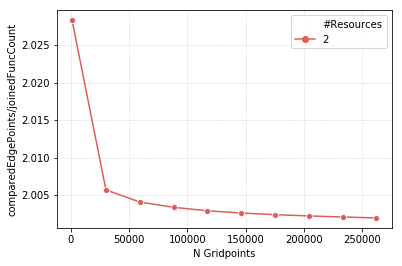

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}


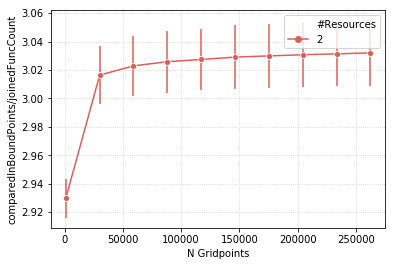

scalability/3-2-(.+) - matching: 10 - valid: 10 - total: 10
Methods: {'2D Binary Search Tree'}


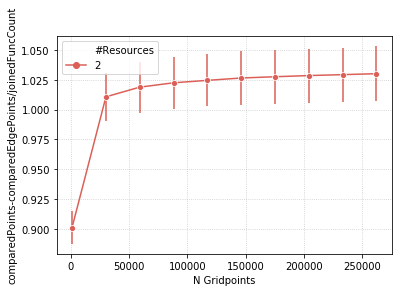

In [47]:
exp_name = 'scalability'
exp_prefix = '3-2'
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'),
                                      fit_method='complexity_pow')
plt.show()
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','dsBuildTime'),
                                      fit_method='complexity_pow_logn')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','totalRuntime'),
                                      fit_method='complexity_pow_logn')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
          val_exp=[('stats','expectedComparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedInBoundPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '-', ('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

In [29]:
df = results.analyze.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','totalRuntime'))
df

scalability/(.+) - matching: 46 - valid: 46 - total: 46
Methods: {'Category Tree', '2D Binary Search Tree'}


,#Resources,N Gridpoints,Method,totalRuntime
0,1,1024,2D Binary Search Tree,0.000257
1,1,1024,2D Binary Search Tree,0.000211
2,1,1024,2D Binary Search Tree,0.000191
3,1,1024,2D Binary Search Tree,0.000190
4,1,1024,2D Binary Search Tree,0.000212
5,1,1024,2D Binary Search Tree,0.000180
6,1,1024,2D Binary Search Tree,0.000176
7,1,1024,2D Binary Search Tree,0.000189
8,1,1024,2D Binary Search Tree,0.000189
9,1,1024,2D Binary Search Tree,0.000198


scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}
Resource 4 fit: 2.7779e-06 * n^(1.72)


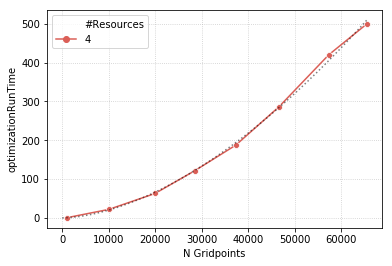

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}
Resource 4 fit: 1.31197e-06 * n^(1.54)


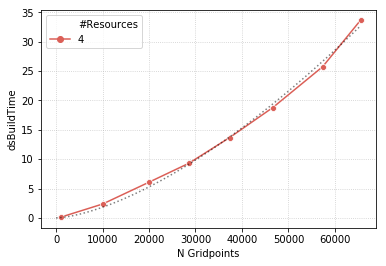

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}


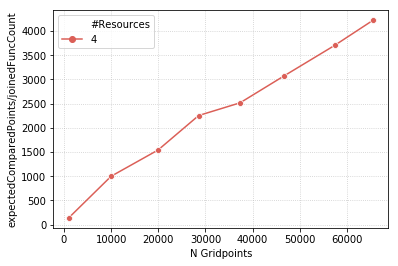

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}


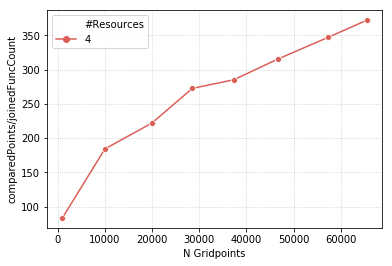

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}


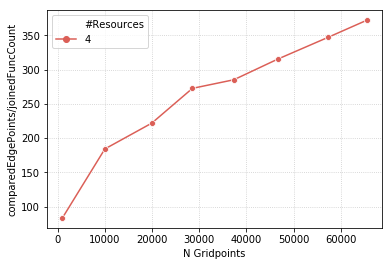

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}


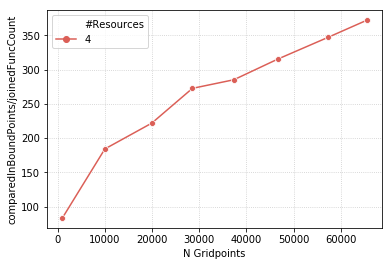

scalability/countedge-3d-brute-2-3-4-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'2D Binary Search Tree'}


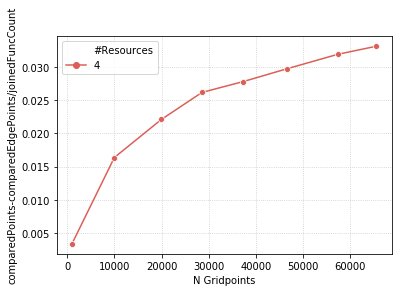

In [74]:
exp_name = 'scalability'
exp_prefix = 'countedge-3d-brute-2-3-4'
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'),
                                      fit_method='complexity_pow')
plt.show()
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','dsBuildTime'),
                                      fit_method='complexity_pow_logn')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
          val_exp=[('stats','expectedComparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedInBoundPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '-', ('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}
Resource 4 fit: 4.58472e-05 * n^(1.45)


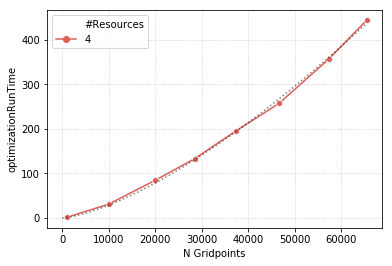

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}
Resource 4 fit: 5.10309e-06 * n^(1.38)


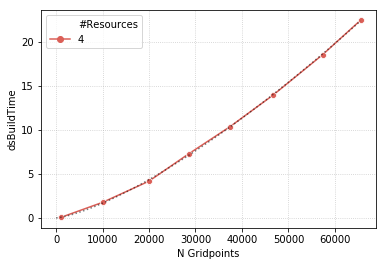

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}


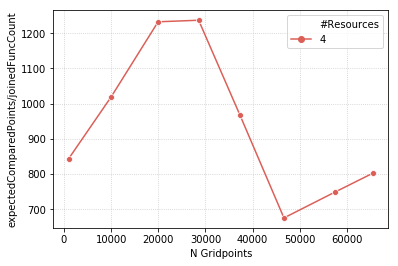

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}


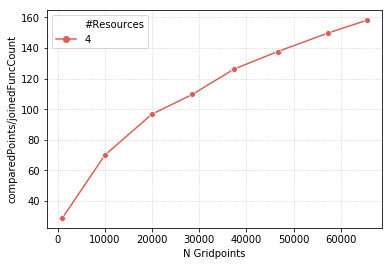

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}


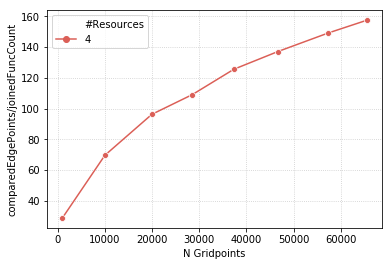

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}


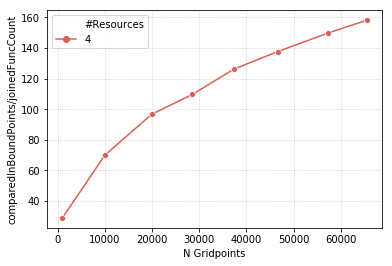

scalability/countedge-3d-part-5-(.+) - matching: 8 - valid: 8 - total: 8
Methods: {'Category Tree'}


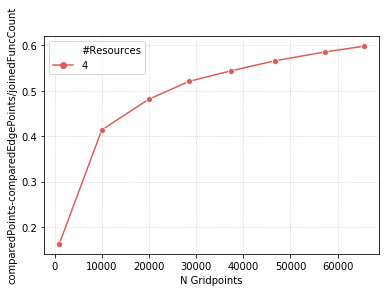

In [73]:
exp_name = 'scalability'
exp_prefix = 'countedge-3d-part-5'
ds_obj = data.nonconcave
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','optimizationRunTime'),
                                      fit_method='complexity_pow_logn')
plt.show()
df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
                                       val=('stats','dsBuildTime'),
                                      fit_method='complexity_pow_logn')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
          val_exp=[('stats','expectedComparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedInBoundPoints'), '/', ('stats','joinedFuncCount')])
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, exp_name, exp_prefix,
        val_exp=[('stats','comparedPoints'), '-', ('stats','comparedEdgePoints'), '/', ('stats','joinedFuncCount')])
plt.show()

gridpoints/buildtime-norec-3m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'2D Range Tree'}


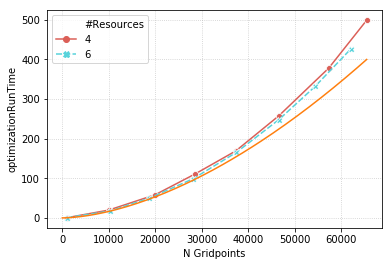

gridpoints/buildtime-norec-3m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'2D Range Tree'}


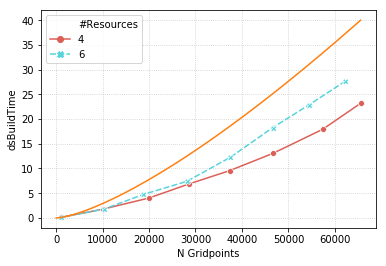

gridpoints/buildtime-norec-3m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'2D Range Tree'}


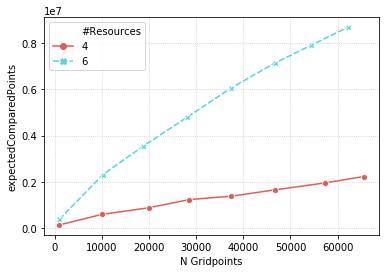

gridpoints/buildtime-norec-3m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'2D Range Tree'}


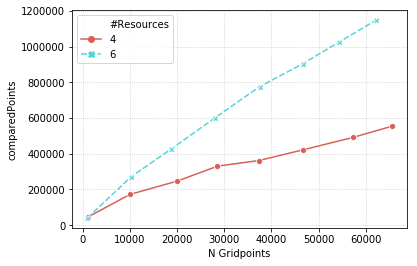

gridpoints/buildtime-norec-3m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'2D Range Tree'}


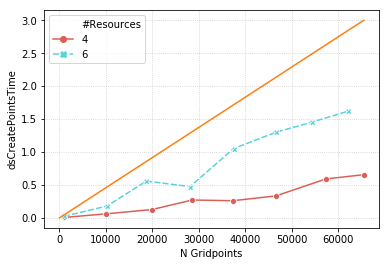

In [8]:
exp_name = 'buildtime-norec-3m'
df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='optimizationRunTime')
x = np.linspace(1, 65536, 128)
p = 1.7
y = (x**p) * 400/ (x[-1]**p)
plt.plot(x, y)
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='dsBuildTime')
x = np.linspace(1, 65536, 128)
y = (x*(np.log2(x)**4)) * (40) / (x[-1]*(np.log2(x[-1])**4))
plt.plot(x, y)

# y = (x*(np.log2(x)**2)) * (6*8) / (x[-1]*(np.log2(x[-1])**2))
# plt.plot(x, y)

# y = (x*(np.log2(x))) * (8) / (x[-1]*(np.log2(x[-1])))
# plt.plot(x, y)

# y = (x**2) * 50/ (x[-1]**2)
# y = (x*(np.log2(x)**4)) * (13) / (x[-1]*(np.log2(x[-1])**4))
# plt.plot(x, y)

plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='expectedComparedPoints')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='comparedPoints')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='dsCreatePointsTime')
x = np.linspace(1, 65536, 128)
y = x * 3 / x[-1]
plt.plot(x, y)

gridpoints/buildtime-17m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'Multi Range Tree'}


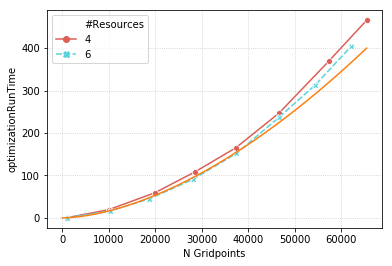

gridpoints/buildtime-17m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'Multi Range Tree'}


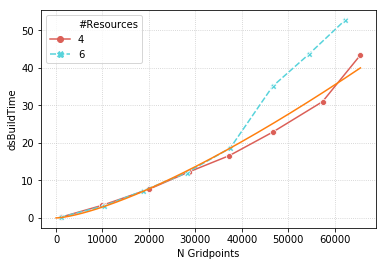

gridpoints/buildtime-17m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'Multi Range Tree'}


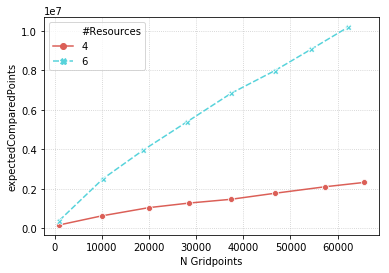

gridpoints/buildtime-17m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'Multi Range Tree'}


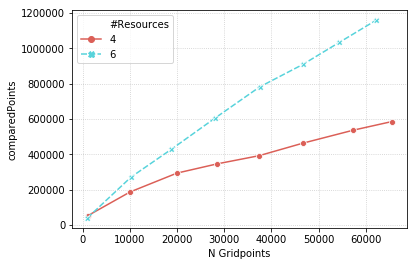

gridpoints/buildtime-17m-(.+) - matching: 16 - valid: 16 - total: 16
Methods: {'Multi Range Tree'}


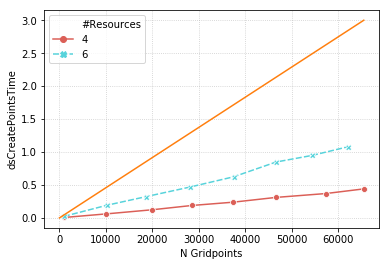

In [9]:
exp_name = 'buildtime-17m'
df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='optimizationRunTime')
x = np.linspace(1, 65536, 128)
p = 1.7
y = (x**p) * 400/ (x[-1]**p)
plt.plot(x, y)
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='dsBuildTime')
x = np.linspace(1, 65536, 128)
y = (x*(np.log2(x)**4)) * (40) / (x[-1]*(np.log2(x[-1])**4))
plt.plot(x, y)

# y = (x*(np.log2(x)**2)) * (6*8) / (x[-1]*(np.log2(x[-1])**2))
# plt.plot(x, y)

# y = (x*(np.log2(x))) * (8) / (x[-1]*(np.log2(x[-1])))
# plt.plot(x, y)

# y = (x**2) * 50/ (x[-1]**2)
# y = (x*(np.log2(x)**4)) * (13) / (x[-1]*(np.log2(x[-1])**4))
# plt.plot(x, y)

plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='expectedComparedPoints')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='comparedPoints')
plt.show()

df = results.plot.joint_val_gridpoints(ds_obj, 'gridpoints', exp_name, timing_val='dsCreatePointsTime')
x = np.linspace(1, 65536, 128)
y = x * 3 / x[-1]
plt.plot(x, y)

In [14]:
sz = 10000
ndim = 2
shape = exp.param.get_shape_for_gridpoints(sz, ndim)
n_chunks = np.subtract(shape, 1)
print(sz, ndim, shape, n_chunks)
vals = data.produce.get_vals(sd, shape, ndim=ndim, factor_wealth=True)
join_method = 3
join_chunk_size = 2
ret = vecfunc.vcg.joint_func(vals, n_chunks, join_method=join_method, join_chunk_size=join_chunk_size,
                             join_stats=True)
ret['stats']

10000 2 (100, 100) [99 99]


{'combinationCount': 29145828,
 'comparedPoints': 2914.5827999999938,
 'dsBuildTime': 1.00796821,
 'dsQueryFetchTime': 1.7638659270000336,
 'dsQueryTime': 2.0771316940000277,
 'expectedCombinationCount': 535198835,
 'expectedComparedPoints': 53519.883499999996,
 'joinedFuncCount': 510,
 'method': '2D Range Tree',
 'optimizationRunTime': 7.280348062515259,
 'totalRuntime': 7.199447085000001}

In [15]:
sz = (250000 + 10000)/2
ndim = 2
shape = exp.param.get_shape_for_gridpoints(sz, ndim)
n_chunks = np.subtract(shape, 1)
print(sz, ndim, shape, n_chunks)
vals = data.produce.get_vals(sd, shape, ndim=ndim, factor_wealth=True)
join_method = 3
join_chunk_size = 2
ret = vecfunc.vcg.joint_func(vals, n_chunks, join_method=join_method, join_chunk_size=join_chunk_size,
                             join_stats=True)
ret['stats']

130000.0 2 (360, 361) [359 360]


{'combinationCount': 425596349,
 'comparedPoints': 3274.825707910134,
 'dsBuildTime': 21.714567267,
 'dsQueryFetchTime': 42.26597189098188,
 'dsQueryTime': 36.652026276003966,
 'expectedCombinationCount': 24886636766,
 'expectedComparedPoints': 191494.5888427209,
 'joinedFuncCount': 510,
 'method': '2D Range Tree',
 'optimizationRunTime': 132.32688355445862,
 'totalRuntime': 132.1452292079999}

In [12]:
sz = 250000
ndim = 2
shape = exp.param.get_shape_for_gridpoints(sz, ndim)
n_chunks = np.subtract(shape, 1)
print(sz, ndim, shape, n_chunks)
vals = data.produce.get_vals(sd, shape, ndim=ndim, factor_wealth=True)
join_method = 3
join_chunk_size = 2
ret = vecfunc.vcg.joint_func(vals, n_chunks, join_method=join_method, join_chunk_size=join_chunk_size,
                             join_stats=True)
ret['stats']

250000 2 (500, 500) [499 499]


{'combinationCount': 839508628,
 'comparedPoints': 3358.0345120000056,
 'dsBuildTime': 52.23691431099999,
 'dsQueryFetchTime': 112.85986819092264,
 'dsQueryTime': 78.28791539305323,
 'expectedCombinationCount': 66365967194,
 'expectedComparedPoints': 265463.86877600005,
 'joinedFuncCount': 510,
 'method': '2D Range Tree',
 'optimizationRunTime': 306.4508571624756,
 'totalRuntime': 306.18707436200003}

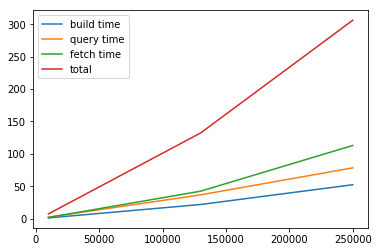

In [20]:
x = 10000, 130000, 250000
y1 = 1.00796821, 21.714567267, 52.23691431099999
y2 = 2.0771316940000277, 36.652026276003966, 78.28791539305323
y3 = 1.7638659270000336, 42.26597189098188, 112.85986819092264
y4 = 7.199447085000001, 132.1452292079999, 306.18707436200003

plt.plot(x, y1, label='build time')
plt.plot(x, y2, label='query time')
plt.plot(x, y3, label='fetch time')
plt.plot(x, y4, label='total')
plt.legend()
None

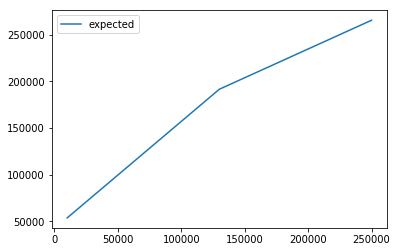

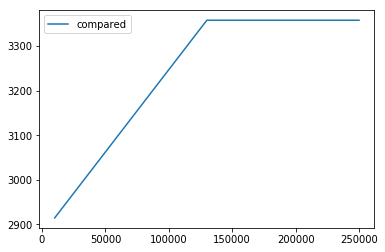

In [22]:
x = 10000, 130000, 250000
y1 = 53519.883499999996, 191494.5888427209, 265463.86877600005
y2 = 2914.5827999999938, 3358.0345120000056, 3358.0345120000056

plt.plot(x, y1, label='expected')
plt.legend()
plt.show()

plt.plot(x, y2, label='compared')
plt.legend()
None